# Benchmark M2.2: Water flow in soil - Evaportation

*by Daniel Leitner, Andrea Schnepf, Valentin Couvreur, Axelle Koch*

In [1]:
import numpy as np
from scipy import integrate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os
import ast
from van_genuchten import *

## Comparison of numerical solutions to reference solution

There are many softwares solving Richards equation. Benchmark M2.2 was evaluated for *Macro*, *Hydrus1D*, *Swap*, *Marthe*, and *Wave* in Vanderborght et al. (2005). With this Jupyter Notebook, we enable automated comparison of the results of additional numerical codes. The easiest way to contribute is to implement this benchmark problem and provide the results to be stored on the specified folder in the github repository.  

In addition, we provide links to Jupyter Notebooks that describe the numerical implementation of a benchmark problem in a specific code if available in sub-folder 'M2.2 Model descriptions'..

### Result data format of M2.2

For an automatic comparison of the numerical results, the results are stored in a text file with two rows containing comma separated time points [day] in the first, and actual evaporation rate [cm day-1] in the second row. This is done for each scenario, with low and high resolution (i.e. 2 (rows) * 4 (scenarios) * 2 (resolutions) results = 16 rows). The file must be located in the sub-folder 'M2.2 Numerical results/.

### Comparison  to the analytical solution

First we define the soil parameters for the scenarios

In [2]:
sand = Parameters(0.045, 0.43, 0.15, 3, 1000) 
loam = Parameters(0.08, 0.43, 0.04, 1.6, 50)
clay = Parameters(0.1, 0.4, 0.01, 1.1, 10)

We prepare the analytical solution and store the results in *y4* [cm$^3$ day$^{-1}$] holding the actual evaporation, and *t4* [day] the corresponding times. 

In [3]:
jwpot_ = [-0.1, -0.1, -0.3, -0.3] # potential eflux (cm/day)
head_i_ = [-40, -200, -200, -200] # initial soil matric potential (cm)

N = 1000
y = np.zeros((N,4))
t = np.linspace(0.,10,N) # days

for i,soil in enumerate([sand, loam, loam, clay]):  
    
    head_i = head_i_[i]
    theta_i = water_content(head_i,soil) # initial theta  
    theta_sur = water_content(-10000,soil) # critical vaule 
    jwpot = jwpot_[i]      
    
    dw = lambda th: water_diffusivity(th,theta_i, theta_sur, soil)    
    int_dw, err = integrate.quad(dw,0,1)    
  
    theta_dw = lambda th: th*water_diffusivity(th,theta_i, theta_sur, soil)       
    int_theta_dw, err = integrate.quad(theta_dw,0,1)
    beta = pow(int_theta_dw/int_dw,2) # Eqn 43

    fun_dw = lambda th: pow(1-th*beta,2)*dw(th)
    alpha, err = integrate.quad(fun_dw,0,1)
    alpha /= int_dw  # Eqn 42

    mu = ( 3*beta*(1+np.sqrt(1-(14/9)*(1-alpha/pow(1-beta,2)) ) ) ) / ( 2*(1-beta)*(alpha/pow(1-beta,2)-1) ) # Eqb 41
    sw = lambda theta_sur, theta_i: (theta_i-theta_sur)*np.sqrt((4/mu)*int_dw) # Eqn 39  
    tdash = (sw(theta_sur, theta_i)*sw(theta_sur, theta_i)) / (4*jwpot*jwpot) # Eqn 44
    tpot =  (sw(theta_sur, theta_i)*sw(theta_sur, theta_i)) / (2*jwpot*jwpot) # Eqn 45
    jw = lambda t: (t<tpot)*jwpot+(t>=tpot)*sw(theta_sur, theta_i)/(2*np.sqrt(abs(tdash+t-tpot))) # eq 46 & 47

    y[:,i] = list(map(jw,t))  # evaluate

t4 = t # remember results for later comparison
y4 = abs(y)

We plot the analytical solutions, and then open all files representing the numerical solution of the different simulators, to create a graph that summarizes the results.

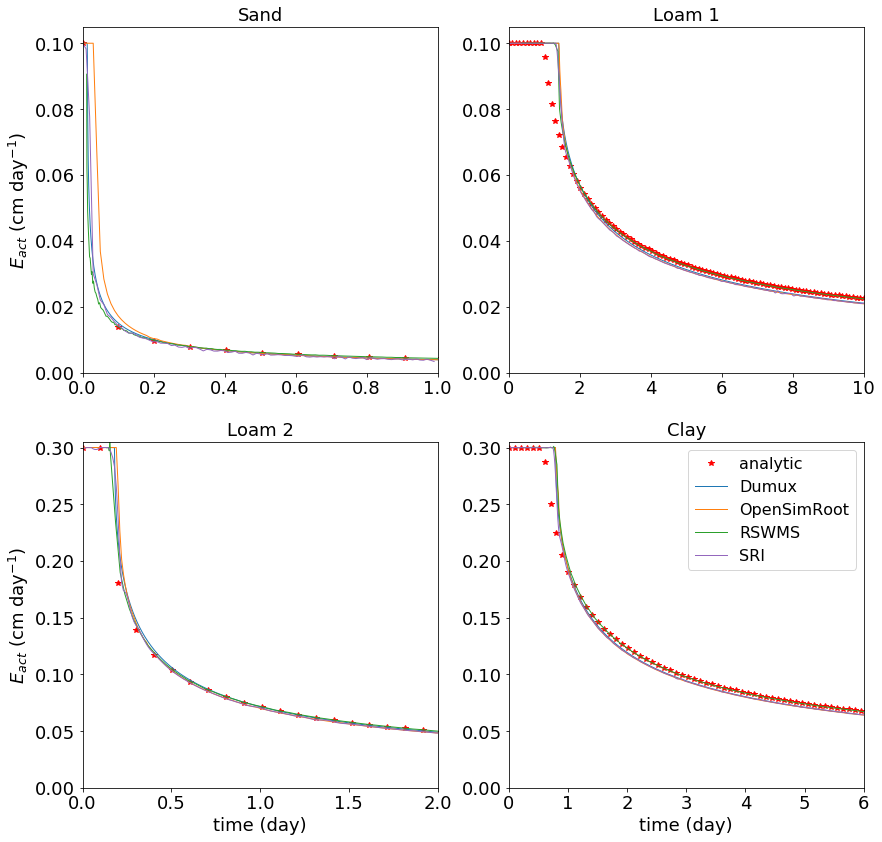

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14))  
l=['analytic']
for j in range(0,4):   
    t_ = np.linspace(0,10,100)
    interp = interp1d(t4, y4[:,j],  kind='linear', fill_value='extrapolate' ) 
    ax[int(j/2),j%2].plot(t_,interp(t_),'r*', label="analytic")  

nrmse, nnse, l, lsoil, levap = [], [], [], [], []
lsoils=["Sand","Loam","Loam","Clay"];
for dirname, dirnames, filenames in os.walk('M2.2 Numerical results/.'):
    filenames.sort()
    for i,f in enumerate(filenames):        
        try:              
            data = []
            with open('M2.2 Numerical results/'+f) as fp: 
                for line in fp:
                    s = ast.literal_eval("["+line+"]")  
                    data.append(s) 
                         
            for j in range(0,8): # 0-3 low res, 4-7 high res                
                t = data[2*j] 
                eva = data[2*j+1]                   
                j_ = j % 4 # scenario index (i.e. 0-3)                           
                eva_a = y4[:,j_] 
                interp = interp1d(t,eva,  kind='nearest', fill_value='extrapolate' ) 
                eva_n = interp(sorted(t4))
                if j>3: # compute measures for higher discretizations                    
                    l.append(f); 
                    nrmse.append(float(nRMSE(eva_a, eva_n)))
                    lsoil.append(lsoils[j_]); levap.append(jwpot_[j_]);
                    ax[int(j_/2),j_%2].plot(t, eva,color=col[i], label=f, linewidth = 1, alpha = 1) 
                    
                if j_>1:
                    ax[int(j_/2),j_%2].set_xlabel("time (day)")
                if j == 0 or j == 2:
                    ax[int(j_/2),j_%2].set_ylabel('$E_{act}$ (cm day$^{-1}$)')                       
        except Exception as ex:
            print("Something went wrong with file "+f)    
            raise
        
ax[0,0].set_ylim(0,0.105) 
ax[0,1].set_ylim(0,0.105) 
ax[1,0].set_ylim(0,0.305) 
ax[1,1].set_ylim(0,0.305) 
ax[0,0].set_xlim(0,1) 
ax[0,1].set_xlim(0,10) 
ax[1,0].set_xlim(0,2) 
ax[1,1].set_xlim(0,6) 
ax[0,0].set_title('Sand');ax[0,1].set_title('Loam 1');ax[1,0].set_title('Loam 2');ax[1,1].set_title('Clay');
plt.legend()
plt.savefig('m22_results.png', dpi=300, bbox_inches = "tight")
plt.show()

Additionally, we create a table using normalised RSME as an error measure (which were calculated in the cell above)

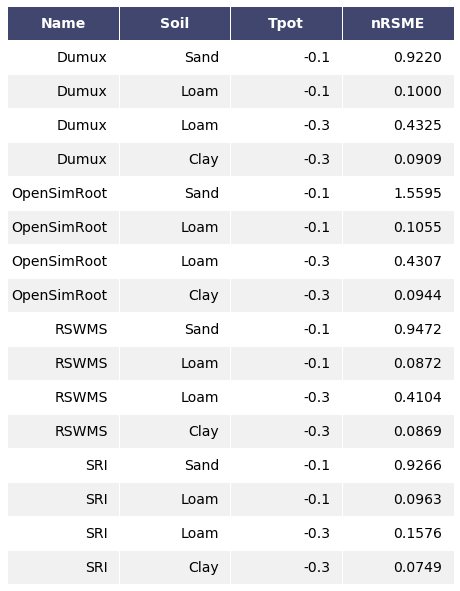

In [5]:
import pandas as pd 

data_ = np.array([l, lsoil, levap, nrmse])
data_ = np.array(data_.transpose())
df = pd.DataFrame(data_, columns = ['Name','Soil','Tpot','nRSME'] ) # Create the pandas DataFrame 
df['Tpot'] = df['Tpot'].astype(float)
df['Tpot'] = df['Tpot'].map('{:,.1f}'.format)
df['nRSME'] = df['nRSME'].astype(float)
df['nRSME'] = df['nRSME'].map('{:,.4f}'.format)
#df['nNSE'] = df['nNSE'].astype(float)
#df['nNSE'] = df['nNSE'].map('{:,.4f}'.format)
df.style.set_table_styles(
[{'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#eee')]}, 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 {'selector': 'th',
  'props': [('background', '#606060'), 
            ('color', 'white'),
            ('font-family', 'verdana')]},
 {'selector': 'td',
  'props': [('font-family', 'verdana')]},
]
).hide_index()

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(df, header_columns=0, col_width=2.0)
fig.savefig("table_m22.png")

## References

Vanderborght, J., Kasteel, R., Herbst, M., Javaux, M., Thiery, D., Vanclooster, M., Mouvet, C., and Vereecken, H. (2005) A set of analytical benchmarks to test numerical models of flow and transport in soils. *Vadose Zone Journal*, 4(1):206-221.